# With SentencePiece tokenizer

## Initial setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *

In [3]:
bs = 512

In [4]:
data_path = Config.data_path()
lang = 'nl'
name = f'{lang}wiki_sp' # Use a different directory.
path = data_path/name
path.mkdir(exist_ok=True, parents=True)
lm_fns = [f'{lang}_wt', f'{lang}_wt_vocab']

## Download wikipedia data

In [5]:
from nlputils import split_wiki,get_wiki

In [6]:
get_wiki(path, lang)

/storage/nlwiki_sp/nlwiki already exists; not downloading


In [7]:
path.ls()

[PosixPath('/storage/nlwiki_sp/wikiextractor'),
 PosixPath('/storage/nlwiki_sp/nlwiki-latest-pages-articles.xml'),
 PosixPath('/storage/nlwiki_sp/nlwiki'),
 PosixPath('/storage/nlwiki_sp/docs'),
 PosixPath('/storage/nlwiki_sp/copy_docs.py')]

### Split in separate files

In [8]:
dest = split_wiki(path, lang)

/storage/nlwiki_sp/docs already exists; not splitting


In [9]:
dest.ls()[:5]

[PosixPath('/storage/nlwiki_sp/docs/Theophanu.txt'),
 PosixPath('/storage/nlwiki_sp/docs/Witte dovenetel.txt'),
 PosixPath('/storage/nlwiki_sp/docs/Minskoffensief.txt'),
 PosixPath('/storage/nlwiki_sp/docs/Cochabamba (stad).txt'),
 PosixPath('/storage/nlwiki_sp/docs/Joel Osteen.txt')]

## Create databunch for language model

In [13]:
# This takes about 45 minutes:
data = (TextList.from_folder(dest, processor=[OpenFileProcessor(), SPProcessor()])
       .split_by_rand_pct(0.1, seed=42)
       .label_for_lm()
       .databunch(bs=bs, num_workers=1))

In [14]:
data.save(f'{lang}_databunch_sp')  # Different databunch
len(data.vocab.itos),len(data.train_ds)

(30000, 183926)

In [15]:
#  data.train_ds[:5]

LabelList (5 items)
x: LMTextList
▁xxbos ▁xxmaj ▁theo pha nu ▁xxmaj ▁theo pha nu ▁( grieks : ▁xxmaj ▁ θ ε ο φ α ν ώ , ▁" the op han o " ▁of ▁xxmaj ▁ θ ε ο φ ά ν ι α , ▁" the op han ia ") ▁( constant ino pel , ▁ca . ▁9 60 ▁ - ▁xxmaj ▁nijmegen , ▁15 ▁juni ▁9 91) ▁was ▁een ▁xxmaj ▁byzantijnse ▁prinses , ▁een ▁( aan getrouwd e ) ▁nicht ▁van ▁de ▁xxmaj ▁byzantijnse ▁keizer ▁xxmaj ▁johannes ▁i ▁xxmaj ▁ tz imi s kes . ▁xxmaj ▁op ▁14 ▁april ▁9 72 ▁huwde ▁zij ▁op ▁ongeveer ▁twaalf jarige ▁leeftijd ▁met ▁keizer ▁xxmaj ▁otto ▁xxup ▁ii ▁en ▁werd ▁zodoende ▁keizerin ▁van ▁het ▁xxmaj ▁heilige ▁xxmaj ▁roomse ▁xxmaj ▁rijk . ▁xxmaj ▁na ▁de ▁dood ▁van ▁xxmaj ▁otto ▁xxup ▁ii ▁werd ▁zij ▁regentes ▁voor ▁haar ▁zoon ▁keizer ▁xxmaj ▁otto ▁xxup ▁iii . ▁xxmaj ▁otto ▁i ▁had ▁voor ▁zijn ▁zoon , ▁xxmaj ▁otto ▁xxup ▁ii , ▁om ▁een ▁xxmaj ▁byzantijnse ▁prinses ▁gevraagd ▁om ▁zo ▁op ▁passen de ▁wijze ▁een ▁verdrag ▁te ▁ver zegel en ▁tussen ▁het ▁xxmaj ▁heilige ▁xxmaj ▁roomse ▁xxmaj ▁rijk ▁en ▁het ▁xxmaj ▁byzantijnse 

In [17]:
# data.show_batch()

idx,text
0,▁een ▁( aan getrouwd e ) ▁nicht ▁van ▁de ▁xxmaj ▁byzantijnse ▁keizer ▁xxmaj ▁johannes ▁i ▁xxmaj ▁ tz imi s kes . ▁xxmaj ▁op ▁14 ▁april ▁9 72 ▁huwde ▁zij ▁op ▁ongeveer ▁twaalf jarige ▁leeftijd ▁met ▁keizer ▁xxmaj ▁otto ▁xxup ▁ii ▁en ▁werd ▁zodoende ▁keizerin ▁van ▁het ▁xxmaj ▁heilige ▁xxmaj ▁roomse ▁xxmaj ▁rijk . ▁xxmaj ▁na ▁de ▁dood ▁van ▁xxmaj ▁otto ▁xxup ▁ii ▁werd ▁zij ▁regentes ▁voor ▁haar ▁zoon ▁keizer
1,"▁schrijver ▁xxmaj ▁joan ▁xxmaj ▁tri ad ú ▁(19 21 -2010 ). ▁xxmaj ▁op ▁23 ▁september ▁2012 ▁is ▁xxmaj ▁ mart í ▁xxmaj ▁gas ull ▁i ▁xxmaj ▁ro ig , ▁stichten d ▁lid ▁en ▁be ziel er ▁van ▁de ▁organisatie , ▁tijdens ▁het ▁berg be klimmen ▁in ▁xxmaj ▁nepal ▁ver ongeluk t . ▁xxmaj ▁te ▁zijn er ▁ere ▁werd ▁in ▁het ▁xxmaj ▁te a tre ▁xxmaj ▁nacional ▁in ▁xxmaj ▁barcelona ▁op"
2,"▁haar ▁leven ▁en ▁beeldend ▁werk ▁van ▁tijdgenoten . ▁xxmaj ▁in ▁2008 ▁werd ▁in ▁haar ▁voormalig ▁woonhuis ▁aan ▁de ▁xxmaj ▁oude kamp ▁1 ▁te ▁xxmaj ▁utrecht ▁een ▁museum ▁ter ▁ere ▁van ▁haar ▁werk ▁ingericht , ▁dat ▁zo ' n ▁vier ▁jaar ▁heeft ▁bestaan . ▁xxmaj ▁vanuit ▁de ▁stichting ▁"" dir kje ▁xxmaj ▁ku ik "" ▁wordt ▁haar ▁artistieke ▁nalatenschap ▁beheerd . ▁xxbos ▁xxmaj ▁kluis ▁van ▁xxmaj ▁santa ▁xxmaj ▁maria ▁della ▁xxmaj"
3,"▁munteenheid ▁die ▁in ▁verschillende ▁xxmaj ▁arabische ▁landen ▁wordt ▁gebruikt , ▁en ▁in ▁"" dine ro "", ▁het ▁xxmaj ▁spaanse ▁woord ▁voor ▁geld . ▁xxmaj ▁ook ▁de ▁oude ▁xxmaj ▁franse ▁munteenheid ▁"" de nier "" ▁is ▁van ▁"" den arius "" ▁afgeleid . ▁xxmaj ▁prijzen ▁in ▁xxmaj ▁engeland ▁werden ▁tot ▁de ▁invoering ▁van ▁het ▁de ci maal ▁systeem ▁uitgedrukt ▁in ▁xxup ▁"" l ▁/ ▁ s ▁/ ▁ d "", ▁voor"
4,". ▁xxmaj ▁arnold ▁werd ▁echter ▁al ▁snel ▁aan ▁de ▁deur ▁gezet ▁en ▁de ▁nieuwe ▁coach ▁van ▁het ▁team ▁had ▁weinig ▁interesse ▁in ▁xxmaj ▁vu ković , ▁voor ▁hem ▁kwam ▁het ▁uiteindelijk ▁niet ▁verder ▁dan ▁2 ▁basisplaats en ▁in ▁de ▁beker ▁en ▁een ▁aantal ▁keer ▁op ▁de ▁bank ▁plaats nemen ▁in ▁de ▁competitie . ▁xxmaj ▁na ▁een ▁passage ▁van ▁1 ▁seizoen ▁bij ▁xxmaj ▁melbourne ▁xxmaj ▁victor y ▁xxup ▁fc ▁tekende ▁xxmaj"


## Train language model

In [10]:
data = load_data(dest, f'{lang}_databunch_sp', bs=bs, num_workers=1)

In [11]:
# data.train_ds[:1]

In [12]:
# learn = language_model_learner(data, AWD_LSTM, drop_mult=0.5, pretrained=False).to_fp16()
# learn = language_model_learner(data, AWD_LSTM, drop_mult=1.0, pretrained=False)
learn = language_model_learner(data, AWD_LSTM, drop_mult=0.5, pretrained=False)

In [13]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


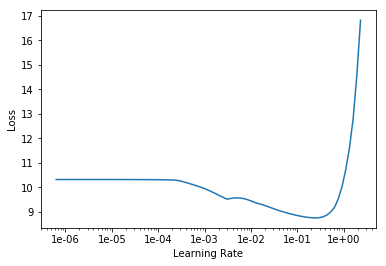

In [23]:
learn.lr_find()
learn.recorder.plot()

In [14]:
# lr = 5e-3
lr = 1e-2

In [15]:
# learn.fit_one_cycle(1, lr, moms=(0.8, 0.7))

In [16]:
# Previous run (lr = 5e-3)
# learn.fit_one_cycle(5, lr, moms=(0.8, 0.7))

In [17]:
learn.fit_one_cycle(10, lr, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.855634,3.813769,0.325507,1:31:38
1,3.701236,3.653547,0.338750,1:31:51
2,3.664930,3.611376,0.342618,1:31:48
3,3.593063,3.534426,0.350695,1:31:48
4,3.523953,3.459822,0.359211,1:31:58
5,3.461168,3.384177,0.367894,1:31:56
6,3.388975,3.302083,0.377617,1:31:46
7,3.327637,3.230100,0.386704,1:31:51
8,3.279748,3.182951,0.392979,1:31:51
9,3.263349,3.170890,0.394636,1:31:50


In [18]:
mdl_path = path/'models'
mdl_path.mkdir(exist_ok=True)
# learn.to_fp32().save(mdl_path/lm_fns[0], with_opt=False)
learn.save(mdl_path/lm_fns[0], with_opt=False)
learn.data.vocab.save(mdl_path/(lm_fns[1] + '.pkl'))

In [19]:
TEXT = "In zijn laatste roman"
N_WORDS = 40
N_SENTENCES = 2

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

In zijn laatste roman ▁xxmaj ▁in ▁proza ▁is ▁xxmaj ▁the ▁xxmaj ▁ twilight ▁xxmaj ▁zone ▁een ▁xxmaj ▁engelstalige ▁ thriller ▁/ ▁horrorfilm ▁uit ▁2008 ▁geregisseerd ▁door ▁xxmaj ▁peter ▁xxmaj ▁gabriel . ▁xxmaj ▁het ▁is ▁de ▁tweede ▁xxmaj ▁ ava ▁xxmaj ▁ ava ▁xxmaj ▁dracula
In zijn laatste roman ▁xxmaj ▁in ▁de ▁xxmaj ▁nederlandse ▁geschiedenis ▁is ▁een ▁roman ▁van ▁xxmaj ▁jan ▁xxmaj ▁ mul isch ▁" de ▁xxmaj ▁ mul ta t uli ▁of ▁xxmaj ▁ pos e " ▁(18 93) ▁en ▁" de ▁xxmaj ▁ paradijs in "


In [20]:
# learn = language_model_learner(data, AWD_LSTM, drop_mult=1., 
#                                   path = path, 
#                                   pretrained_fnames=lm_fns)
learn.export()

In [21]:
TEXT = '''Albert Einstein

Albert Einstein'''
N_WORDS = 500
N_SENTENCES = 1

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Albert Einstein

Albert Einstein ▁( berlijn , ▁30 ▁juni ▁1926 ▁ - ▁xxmaj ▁amsterdam , ▁11 ▁augustus ▁1985) ▁was ▁een ▁xxmaj ▁duits ▁componist , ▁muziekpedagoog ▁en ▁muziekpedagoog . ▁xxmaj ▁hij ▁is ▁actief ▁in ▁de ▁muziek , ▁ akoestiek ▁en ▁componeren . ▁xxmaj ▁hij ▁was ▁de ▁zoon ▁van ▁een ▁piano bouwer . ▁xxmaj ▁anton ▁xxmaj ▁weiss ▁was ▁een ▁neef ▁van ▁xxmaj ▁ fran tz ▁xxmaj ▁david ▁xxmaj ▁kri zing . ▁xxmaj ▁in ▁de ▁jaren ▁dertig ▁van ▁de ▁20 e ▁eeuw ▁was ▁hij ▁een ▁van ▁de ▁eerste n ▁die ▁aan ▁de ▁ methodologie ▁van ▁het ▁xxmaj ▁ musik paleis ▁in ▁xxmaj ▁berlijn ▁een ▁bijdrage ▁leveren , ▁hetgeen ▁hem ▁in ▁xxmaj ▁berlijn ▁een ▁vooraanstaande ▁plaats ▁bezorgde . ▁xxmaj ▁bij ▁xxmaj ▁fritz ▁xxmaj ▁ rie ß lein ▁was ▁hij ▁docent ▁aan ▁het ▁xxmaj ▁residentie ▁xxmaj ▁conservatorium ▁in ▁xxmaj ▁leipzig . ▁xxmaj ▁tot ▁1937 ▁verbleef ▁hij ▁in ▁xxmaj ▁berlijn . ▁xxmaj ▁als ▁componist ▁xxmaj ▁frédéric ▁xxmaj ▁chopin ▁schreef ▁hij ▁vooral ▁voor ▁de ▁xxmaj ▁ accademia ▁de i ▁xxmaj ▁camera no , ▁d